In [1]:
import pandas as pd
import numpy as np

In [2]:
df = pd.read_csv('compas-scores-two-years.csv')
df.head()

,id,name,first,last,compas_screening_date,sex,dob,age,age_cat,race,...,v_decile_score,v_score_text,v_screening_date,in_custody,out_custody,priors_count.1,start,end,event,two_year_recid
0,1,miguel hernandez,miguel,hernandez,2013-08-14,Male,1947-04-18,69,Greater than 45,Other,...,1,Low,2013-08-14,2014-07-07,2014-07-14,0,0,327,0,0
1,3,kevon dixon,kevon,dixon,2013-01-27,Male,1982-01-22,34,25 - 45,African-American,...,1,Low,2013-01-27,2013-01-26,2013-02-05,0,9,159,1,1
2,4,ed philo,ed,philo,2013-04-14,Male,1991-05-14,24,Less than 25,African-American,...,3,Low,2013-04-14,2013-06-16,2013-06-16,4,0,63,0,1
3,5,marcu brown,marcu,brown,2013-01-13,Male,1993-01-21,23,Less than 25,African-American,...,6,Medium,2013-01-13,NaN,NaN,1,0,1174,0,0
4,6,bouthy pierrelouis,bouthy,pierrelouis,2013-03-26,Male,1973-01-22,43,25 - 45,Other,...,1,Low,2013-03-26,NaN,NaN,2,0,1102,0,0


In [20]:
df2 = df.query('is_recid != -1') \
    .query('days_b_screening_arrest <= 30') \
    .query('days_b_screening_arrest >= -30') \
    .query('c_charge_degree != "O"') \
    .query('score_text != "N/A"') \
#     .query('race != "Asian"') # small sample size for Asians
print('Dropped %d records. New row count is %d.' % (df.count()[0]-df2.count()[0],df2.count()[0]))

Dropped 1042 records. New row count is 6172.


In [21]:
# Add race abbr
def race_abbr(race):
    if race == 'African-American':
        return 'afr'
    elif race == 'Caucasian':
        return 'whi'
    elif race == 'Hispanic':
        return 'his'
    else:
        return 'oth'
df2['race_abbr'] = df2.apply(lambda x: race_abbr(x['race']),axis=1)

In [22]:
def analyze(df,races=None,risk_indicator='v_score_text'):
    race_list = df.race.unique() if races == None else races
    data = []
    for i,r in enumerate(race_list):
        df1 = df[df['race'] == r]
        no_recid_filter = 'two_year_recid == 0'
        low_risk_filter = '%s == "Low"' % risk_indicator
        low_risk, no_recid = df1.query(low_risk_filter).count()[0], df1.query(no_recid_filter).count()[0]
        accuracy = (df1.query(low_risk_filter).query(no_recid_filter).count()[0] + df1.query('%s != "Low"' % risk_indicator).query('two_year_recid == 1').count()[0])*1.0/df1.count()[0]
        data.append({
            'race': r,
            'total': df1.count()[0],
            'low_risk': df1.query(low_risk_filter).count()[0],
            'no_recid': df1.query(no_recid_filter).count()[0],
            'positive_rate': np.round(low_risk*1.0/df1.count()[0],decimals=2),
            'true_positive_rate': np.round(df1.query(low_risk_filter).query(no_recid_filter).count()[0] * 1.0 / no_recid,decimals=2),
            'accuracy': np.round(accuracy,decimals=2)
        })
    output = pd.DataFrame(data)
    return output[['race','total','no_recid','low_risk','positive_rate','true_positive_rate','accuracy']]
    

In [23]:
analyze(df2).sort_values(by=['true_positive_rate'],ascending=False)[['race','total','accuracy','positive_rate','true_positive_rate']]

,race,total,accuracy,positive_rate,true_positive_rate
4,Asian,31,0.84,0.84,0.96
0,Other,343,0.67,0.78,0.85
2,Caucasian,2103,0.64,0.78,0.85
5,Native American,11,0.82,0.55,0.83
3,Hispanic,509,0.64,0.74,0.81
1,African-American,3175,0.62,0.56,0.69


In [24]:
# Gather some crosstab data
for r in ['African-American','Caucasian']:
    print(r)
    xtab = df2[df2['race'] == r][['v_score_text','two_year_recid','id']]
    xtab['v_score_text'] = xtab['v_score_text'].apply(lambda x: 'Low' if x == 'Low' else 'Med/High')
    print(pd.pivot_table(data=xtab,index='v_score_text',columns='two_year_recid',aggfunc='count').reset_index())

African-American
               v_score_text    id     
two_year_recid                  0    1
0                       Low  1046  743
1                  Med/High   468  918
Caucasian
               v_score_text    id     
two_year_recid                  0    1
0                       Low  1084  564
1                  Med/High   197  258


In [25]:
from sklearn import preprocessing

def append_weights(df,names,mean,std):
    for i,n in enumerate(names):
        df[n] = np.transpose(np.random.normal(size=len(df),loc=mean[i],scale=std[i]))
    return df

def equal_opportunity_adjustor(row,assessment='Risk of Violence',cutoff=4):
    raw_score = row['v_decile_score'] if assessment == 'Risk of Violence' else row['decile_score']
    # If raw score meets the cutoff, stop processing and return value
    if raw_score <= cutoff:
        return 'Low'
    # Otherwise, apply transformations and see if we meet the threshold
    else:
        adj_col = 'adj_%s' % row['race_abbr']
        if adj_col in row.keys():
            score = raw_score - row[adj_col]
        else:
            score = raw_score
        if score <= cutoff:
            return 'Low'
        else:
            return 'Med/High'

def score(df,threshold=0.01,risk_indicator='adjusted_score_text'):
    race_list = ['African-American','Caucasian','Hispanic','Other']
    data = analyze(df,races=race_list,risk_indicator=risk_indicator)
    print(data[['race','positive_rate','true_positive_rate','accuracy']])
    deviations = data['true_positive_rate'].values
    if np.std(deviations) < threshold:
        adjustments = np.empty(shape=0)
    else:
        adjustments = preprocessing.scale(deviations)
    result = {
        'data': data,
        'adjustments': adjustments
    }
    return result
         
    

In [38]:
# Set starting weights
weights = {
    'names': ['adj_afr','adj_whi','adj_his','adj_oth'],
    'means': [0]*4,
    'std': [1]*4
}
result_data = []
initial_score = score(df2,risk_indicator='v_score_text')
initial_score['data']['iteration'] = 0
for row in initial_score['data'].to_dict(orient='records'):
    result_data.append(row)
    
# Start the optimization
for iter in range(10):        
    df3 = append_weights(df2,names=weights['names'],mean=weights['means'],std=weights['std'])
    # Apply transformation
    df3['adjusted_score_text'] = df3.apply(lambda row: equal_opportunity_adjustor(row),axis=1)
    result = score(df3,risk_indicator='adjusted_score_text')
    # Append results
    result['data']['iteration'] = iter+1
    for row in result['data'].to_dict(orient='records'):
        result_data.append(row)
    if len(result['adjustments']) == 0:
        break
    else:
        # Adjust weights based on feedback
        weights['means'] -= (np.round(result['adjustments'],decimals=1))/3.0
        weights['std'] -= (np.round(result['adjustments'],decimals=1))/5.0
        for i,w in enumerate(weights['std']):
            if w <= 0:
                weights['std'][i] = 0.1

               race  positive_rate  true_positive_rate  accuracy
0  African-American           0.56                0.69      0.62
1         Caucasian           0.78                0.85      0.64
2          Hispanic           0.74                0.81      0.64
3             Other           0.78                0.85      0.67
               race  positive_rate  true_positive_rate  accuracy
0  African-American           0.58                0.71      0.62
1         Caucasian           0.79                0.85      0.63
2          Hispanic           0.76                0.82      0.65
3             Other           0.80                0.87      0.67
               race  positive_rate  true_positive_rate  accuracy
0  African-American           0.62                0.73      0.60
1         Caucasian           0.79                0.85      0.64
2          Hispanic           0.76                0.83      0.65
3             Other           0.79                0.86      0.67
               race  posi

In [39]:
pd.DataFrame(result_data)

,accuracy,iteration,low_risk,no_recid,positive_rate,race,total,true_positive_rate
0,0.62,0,1789,1514,0.56,African-American,3175,0.69
1,0.64,0,1648,1281,0.78,Caucasian,2103,0.85
2,0.64,0,379,320,0.74,Hispanic,509,0.81
3,0.67,0,269,219,0.78,Other,343,0.85
4,0.62,1,1852,1514,0.58,African-American,3175,0.71
5,0.63,1,1671,1281,0.79,Caucasian,2103,0.85
6,0.65,1,387,320,0.76,Hispanic,509,0.82
7,0.67,1,274,219,0.80,Other,343,0.87
8,0.60,2,1980,1514,0.62,African-American,3175,0.73
9,0.64,2,1666,1281,0.79,Caucasian,2103,0.85


In [18]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

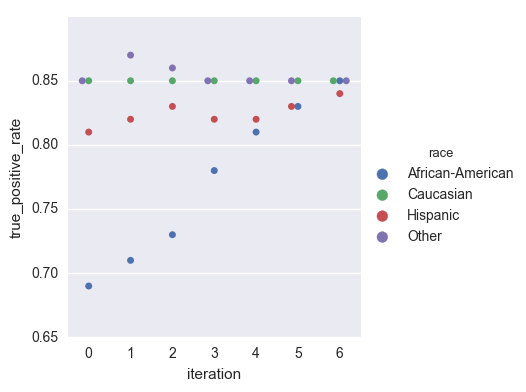

In [40]:
data1 = pd.DataFrame(result_data)
sns.factorplot(x='iteration',y='true_positive_rate',hue='race',kind='swarm',data=data1)

In [46]:
pd.DataFrame(data=weights)

,means,names,std
0,2.433333,adj_afr,2.46
1,-1.366667,adj_whi,0.18
2,0.533333,adj_his,1.32
3,-1.533333,adj_oth,0.08


In [57]:
compare = pd.DataFrame([x for x in result_data if x['iteration'] in(0,6)])[['iteration','race','positive_rate','true_positive_rate','accuracy']]
compare.pivot_table(index='race',columns='iteration')

positive_rate       true_positive_rate       accuracy      
iteration                    0     6                  0     6        0     6
race                                                                        
African-American          0.56  0.76               0.69  0.85     0.62  0.58
Caucasian                 0.78  0.78               0.85  0.85     0.64  0.64
Hispanic                  0.74  0.78               0.81  0.84     0.64  0.64
Other                     0.78  0.78               0.85  0.85     0.67  0.67